# Imports

In [38]:
from time import time
import sys
import os
from copy import deepcopy

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import jax
import jax.tree_util as jtu
import jax.numpy as jnp

from functools import partial
from scipy.io import savemat

import optax
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from base import loss_fn, predict_fn, get_params
from utils import train_fn, latexify
from data import generate_heinonen_gp_data

jax.config.update("jax_enable_x64", True)

%reload_ext watermark

# Config

In [39]:
gen_flex_dict = {"ell": 1, "sigma": 1, "omega": 1}
method = "delta_inducing"  # "heinonen" or "delta_inducing"
latent_seed = 203
latent_key = jax.random.PRNGKey(latent_seed)
data_seed = 303
data_key = jax.random.PRNGKey(data_seed)
default_params = False

n_train = 20
n_selections = 30

# Dataset

In [59]:
X_key = jax.random.PRNGKey(0)
X = jax.random.uniform(X_key, shape=(300, 1), minval=-3, maxval=3).sort(axis=0)
X_test = jnp.linspace(-4, 4, 400).reshape(-1, 1)
y, y_clean, ell, sigma, omega = generate_heinonen_gp_data(
    X, latent_key, data_key, gen_flex_dict
)

save_name = f"recover_{method}_{latent_seed}_{data_seed}_{gen_flex_dict['ell']}_{gen_flex_dict['sigma']}_{gen_flex_dict['omega']}"

savemat(f"data/{save_name}.mat", {save_name: {"X": X, "y": y}})  # to run in matlab

# Normalize
# x_scaler = MinMaxScaler()
# X = x_scaler.fit_transform(X)
# xscale = x_scaler.data_max_ - x_scaler.data_min_
yscale = jnp.max(jnp.abs(y - jnp.mean(y)))
ymean = jnp.mean(y)
y = (y - ymean) / yscale
y_clean = (y_clean - ymean) / yscale
omega = omega / yscale

# Initial setup

In [5]:
# Split into train and test
train_idx, _ = train_test_split(jnp.array(range(len(y))), train_size=n_train, random_state=42)

# AL

In [6]:
def run(train_idx, model_flex_dict): # al_method = "ae" or "e"
    (train_idx, model_flex_dict) = jtu.tree_map(lambda x:x, (train_idx, model_flex_dict))
    preds = []
    best_params = None
    for i in range(n_selections):
        X_train, y_train = X[train_idx], y[train_idx]
        
        value_and_grad_fn = partial(loss_fn, X=X_train, y=y_train, flex_dict=model_flex_dict, method=method)
        partial_get_params = partial(
            get_params, X=X_train, flex_dict=model_flex_dict, method=method, default=default_params, n_inducing=10
        )
        if best_params is None:
            params = jax.vmap(partial_get_params)(jax.random.split(jax.random.PRNGKey(i+1000), 10))
        else:
            params = jax.vmap(partial_get_params)(jax.random.split(jax.random.PRNGKey(i+1000), 9))
            params = jtu.tree_map(lambda old, other: jnp.concatenate([old.reshape(1, *old.shape), other]), best_params, params)

        n_iters = 5000
        partial_train_fn = partial(
            train_fn, loss_fn=value_and_grad_fn, optimizer=optax.adam(0.001), n_iters=n_iters
        )
        results = jax.vmap(partial_train_fn)(init_raw_params=params)
        # print("Losses: ", results["loss_history"][:, -1])
        best_idx = jnp.nanargmin(results["loss_history"][:, -1])
        result = jtu.tree_map(lambda x: x[best_idx], results)
        best_params = result["raw_params"]
        
        pred_mean, pred_var, pred_ell, pred_sigma, pred_omega = predict_fn(
            best_params,
            X_train,
            y_train,
            X,
            model_flex_dict,
            method,
        )
        
        preds.append(pred_mean)
        
        # Select next point
        pred_scale = jnp.sqrt(pred_var)
        pred_scale = pred_scale.at[train_idx].set(-jnp.inf)
        
        idx = jnp.argmax(pred_scale)
        
        train_idx = jnp.concatenate([train_idx, jnp.array([idx])])
        
        print(train_idx.shape, end=" ")
    
    return train_idx, preds, best_params

In [8]:
init = time()
ns_train_idx, ns_preds, ns_best_params = run(train_idx, {"ell": 1, "sigma": 1, "omega": 1})
print("NS time: ", (time() - init)/60, " mins")
chk = time()
s_train_idx, s_preds, s_best_params = run(train_idx, {"ell": 0, "sigma": 0, "omega": 0})
print("S time: ", (time() - chk)/60, " mins")

(21,) (22,) (23,) (24,) (25,) (26,) (27,) (28,) (29,) (30,) (31,) (32,) (33,) (34,) (35,) (36,) (37,) (38,) (39,) (40,) (41,) (42,) (43,) (44,) (45,) (46,) (47,) (48,) (49,) (50,) NS time:  7.181487170855204  mins
(21,) (22,) (23,) (24,) (25,) (26,) (27,) (28,) (29,) (30,) (31,) (32,) (33,) (34,) (35,) (36,) (37,) (38,) (39,) (40,) (41,) (42,) (43,) (44,) (45,) (46,) (47,) (48,) (49,) (50,) S time:  4.010018527507782  mins


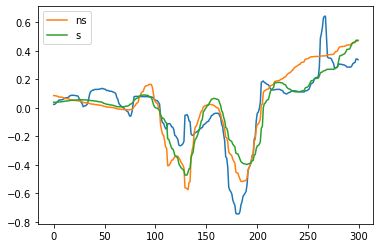

In [42]:
plt.plot(y_clean);
i = 0
plt.plot(ns_preds[i], label='ns');
plt.plot(s_preds[i], label='s');
plt.legend();

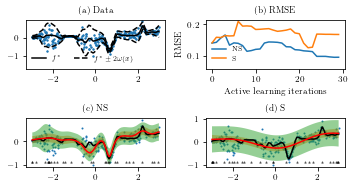

In [98]:
X_train_ns = X[ns_train_idx]
y_train_ns = y[ns_train_idx]
X_train_s = X[s_train_idx]
y_train_s = y[s_train_idx]

latexify(fig_width=5.0, fig_height=2.7)
fig, ax = plt.subplots(2, 2)
ax = ax.ravel()

ax[0].scatter(X, y, s=2)
ax[0].plot(X, y_clean, color="k", linestyle="-", label="$f^*$")
# ax[0].fill_between(X[:, 0], y_clean - 2 * omega, y_clean + 2 * omega, alpha=0.2)
ax[0].plot(X, y_clean + 2 * omega, linestyle="--", color="k", label="$f^* \pm 2\omega(x)$")
ax[0].plot(X, y_clean - 2 * omega, linestyle="--", color="k")
# show legend without boundary box and with 1 row
ax[0].legend(ncol=2, frameon=False, loc="lower left")
ax[0].set_ylim(ax[0].get_ylim()[0]-0.6, ax[0].get_ylim()[1])
ax[0].set_title("(a) Data")

# RMSE
rmse_fn = lambda y, y_pred: jnp.sqrt(jnp.mean((y - y_pred)**2))
ns_rmse = [rmse_fn(y_clean, y_pred) for y_pred in ns_preds]
s_rmse = [rmse_fn(y_clean, y_pred) for y_pred in s_preds]

ax[1].plot(ns_rmse, label="NS");
ax[1].plot(s_rmse, label="S");
ax[1].legend(loc="lower left", frameon=False);
ax[1].set_xlabel("Active learning iterations")
ax[1].set_ylabel("RMSE")
ax[1].set_ylim(ax[1].get_ylim()[0]-0.03, ax[1].get_ylim()[1])
ax[1].set_title("(b) RMSE")

for title, X_train_i, axi, ell_i, sigma_i, omega_i, params in [("(c) NS", X_train_ns, 2, 1, 1, 1, ns_best_params), ("(d) S", X_train_s, 3, 0, 0, 0, s_best_params)]:
    pred_mean, pred_var, pred_ell, pred_sigma, pred_omega = predict_fn(
        params,
        X_train_ns,
        y_train_ns,
        X,
        {"ell": ell_i, "sigma": sigma_i, "omega": omega_i},
        method,
    )

    ax[axi].scatter(X, y, s=1)
    ax[axi].plot(X, y_clean, label="True function", color='k')
    ax[axi].plot(X, pred_mean, label=r"$\mathbb{E}(f^*(x))$", color='r')

    ax[axi].fill_between(
        X[:, 0],  # x
        pred_mean - 2 * jnp.sqrt(pred_var),  # y1
        pred_mean + 2 * jnp.sqrt(pred_var),  # y2
        alpha=0.5,
        label="95\% CI",
    )
    ax[axi].fill_between(
        X[:, 0],  # x
        pred_mean - 2 * jnp.sqrt(pred_var + pred_omega**2),  # y1
        pred_mean + 2 * jnp.sqrt(pred_var + pred_omega**2),  # y2
        alpha=0.5,
        label="95\% CI + noise",
    );

    for x in X_train_i[n_train:]:
        ax[axi].scatter(x, -0.90, color="k", alpha=0.5, marker="^", s=2)
        
    ax[axi].set_title(f"{title}")

fig.tight_layout()
fig.savefig("figures/active_learning.pdf")